# 1. Installing and importing the dependencies

In [1]:
!pip install pystan
!pip install fbprophet
#conda install -c conda-forge fbprophet (for anaconda environment)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

# 2. Reading and preprocessing data

In [3]:
# Load Our Dataset
df = pd.read_csv("peyton_manning.csv")

In [4]:
df.head(10)

,Date,Views
0,12/10/2007,14629
1,12/11/2007,5012
2,12/12/2007,3582
3,12/13/2007,3205
4,12/14/2007,2680
5,12/15/2007,2401
6,12/16/2007,4510
7,12/17/2007,6831
8,12/18/2007,4370
9,12/19/2007,3196


In [5]:
df.tail(10)

,Date,Views
2895,1/11/2016,4773
2896,1/12/2016,3412
2897,1/13/2016,3188
2898,1/14/2016,3052
2899,1/15/2016,3047
2900,1/16/2016,2483
2901,1/17/2016,10656
2902,1/18/2016,30754
2903,1/19/2016,9190
2904,1/20/2016,7269


In [18]:
df.shape

(2905, 2)

In [19]:
df.dtypes

Date     object
Views     int64
dtype: object

## Check to See if our dataset is Stationary
- Visual Representation Test
- Summary of Stats
- AD Fuller Test(null)
    - determine the presence of unit root in the series
    - null hypothesis and alternate hypothesis
    - test stats < critical value is stationary
    
Here we have used used the visual plot test and the AD Fuller test to determine if our dataset is stationary.

### Visual Plot test

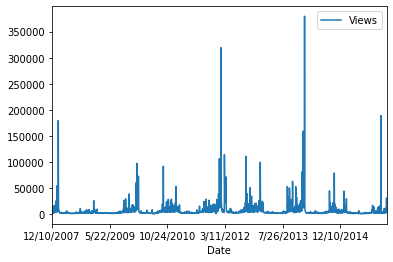

In [6]:
#plot test
df.plot(x = 'Date')

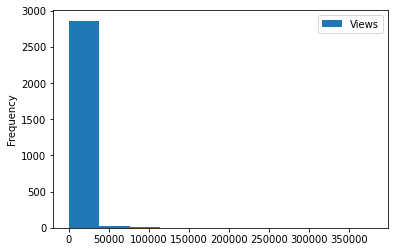

In [8]:
# Histogram
df.plot(kind="hist")

### Conclusion
- The distribution is not a gaussian bell curve. Therefore,  not stationary

### Augment Dickey Fuller Test


In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
def adf_test(timeseries):
    print ('Results of Aug. Dickey-Fuller Test:')
    df_test = adfuller(timeseries, autolag='AIC')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
       df_output['Critical Value {}'.format(key)] = value
    print (df_output)

In [10]:
adf_test(df['Views'])

Results of Aug. Dickey-Fuller Test:
Test Statistic                -7.596906e+00
p-value                        2.446718e-11
#Lags Used                     2.200000e+01
Number of Observations Used    2.882000e+03
Critical Value 1%             -3.432621e+00
Critical Value 5%             -2.862543e+00
Critical Value 10%            -2.567304e+00
dtype: float64


In [11]:
#function to check if stationary
def is_stationary(stats,critical_value):
    if stats < critical_value == True:
        print("Stationary")
    else:
        print("Not Stationary")

In [13]:
is_stationary(-7.596906e+00,-3.432621e+00)

Not Stationary


### Conclusion
Test Stats is greater than Critical Value at all point hence it is not Not Stationary

## Making the dataset Stationary
- Difference Method
    - df.diff
    - yt = yt -y(t-1)
    - df['diff'] = df['a'] - df['a'].shift(1)
- Log Transformation :to stabilize the non consistence values
    - using numpy.log()
    
Here the Log transformation is used

In [9]:
df['Views'] = np.log(df['Views'])

In [10]:
df.head()

,Date,Views
0,12/10/2007,9.590761
1,12/11/2007,8.519590
2,12/12/2007,8.183677
3,12/13/2007,8.072467
4,12/14/2007,7.893572


In [11]:
df.dtypes

Date     object
Views     int64
dtype: object

In [12]:
# convert "Date" column to Datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
df.dtypes

Date     datetime64[ns]
Views           float64
dtype: object

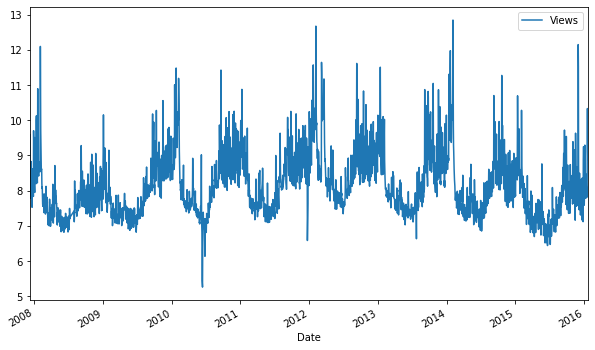

In [19]:
df.plot(x = 'Date', figsize = (10, 6))

### Conclusion
Our Dataset is now stationary and preprocessed

# 3. Building the Prophet Model

### Intro To Facebook Prophet
- Steps
    - Initialize Model :: Prophet()
    - Set columns as ds,y
    - Fit dataset :: Prophet().fit()
    - Create Dates To predict :: Prophet().make_future_dataframe(periods=365)
    - Predict :: Prophet().predict(future_dates)
    - Plot :: Prophet().plot(predictions)

In [20]:
# Initialize the Model
model = Prophet()

In [19]:
#All the methods in prophet object
dir(Prophet)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_country_holidays',
 'add_group_component',
 'add_regressor',
 'add_seasonality',
 'construct_holiday_dataframe',
 'fit',
 'fourier_series',
 'initialize_scales',
 'linear_growth_init',
 'logistic_growth_init',
 'make_all_seasonality_features',
 'make_future_dataframe',
 'make_holiday_features',
 'make_seasonality_features',
 'parse_seasonality_args',
 'piecewise_linear',
 'piecewise_logistic',
 'plot',
 'plot_components',
 'predict',
 'predict_seasonal_components',
 'predict_trend',
 'predict_uncertainty',
 'predictive_samples',
 'regressor_column_matrix',
 'sample_model',
 'sample_posterior_predictive',
 'sample_pre

In [21]:
#rename the "date" column as 'ds' and "Views" column as 'y'
df.columns = ['ds','y']
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [22]:
# Fit our Model to peyton manning Dataset
model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


- The model has automatically identified our dataset has a yearly seasonality and a weekly seasonality. Since there is not daily seasonality, it has been disabled. We can manually enable/disable it if needed

In [23]:
# Create Future Dates of 360 days
future_dates = model.make_future_dataframe(periods=365)

In [24]:
future_dates.head()

,ds
0,2007-12-10
1,2007-12-11
2,2007-12-12
3,2007-12-13
4,2007-12-14


In [26]:
future_dates.tail(10)

,ds
3260,2017-01-10
3261,2017-01-11
3262,2017-01-12
3263,2017-01-13
3264,2017-01-14
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


# 4. Obtaining the forecasts

In [25]:
# Make Prediction with our Model
prediction = model.predict(future_dates)

In [26]:
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-12-10,8.041328,8.211735,9.450833,8.041328,8.041328,0.803017,0.803017,0.803017,0.352288,0.352288,0.352288,0.450728,0.450728,0.450728,0.0,0.0,0.0,8.844345
1,2007-12-11,8.039781,8.031071,9.245068,8.039781,8.039781,0.553104,0.553104,0.553104,0.119642,0.119642,0.119642,0.433462,0.433462,0.433462,0.0,0.0,0.0,8.592885
2,2007-12-12,8.038235,7.793505,9.018983,8.038235,8.038235,0.350467,0.350467,0.350467,-0.066663,-0.066663,-0.066663,0.417131,0.417131,0.417131,0.0,0.0,0.0,8.388702
3,2007-12-13,8.036688,7.733498,8.961108,8.036688,8.036688,0.329920,0.329920,0.329920,-0.072259,-0.072259,-0.072259,0.402179,0.402179,0.402179,0.0,0.0,0.0,8.366608
4,2007-12-14,8.035142,7.775224,8.927745,8.035142,8.035142,0.319438,0.319438,0.319438,-0.069575,-0.069575,-0.069575,0.389013,0.389013,0.389013,0.0,0.0,0.0,8.354580


In [29]:
prediction.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3265,2017-01-15,7.186250,7.513225,8.957790,6.844155,7.544742,1.018036,1.018036,1.018036,0.048282,0.048282,0.048282,0.969754,0.969754,0.969754,0.0,0.0,0.0,8.204286
3266,2017-01-16,7.185220,7.805452,9.256766,6.841014,7.548268,1.344070,1.344070,1.344070,0.352288,0.352288,0.352288,0.991782,0.991782,0.991782,0.0,0.0,0.0,8.529291
3267,2017-01-17,7.184191,7.608902,9.012936,6.837872,7.549198,1.132509,1.132509,1.132509,0.119642,0.119642,0.119642,1.012866,1.012866,1.012866,0.0,0.0,0.0,8.316700
3268,2017-01-18,7.183162,7.458016,8.905993,6.834731,7.549486,0.966140,0.966140,0.966140,-0.066663,-0.066663,-0.066663,1.032803,1.032803,1.032803,0.0,0.0,0.0,8.149302
3269,2017-01-19,7.182133,7.439385,8.912609,6.832137,7.549773,0.979089,0.979089,0.979089,-0.072259,-0.072259,-0.072259,1.051348,1.051348,1.051348,0.0,0.0,0.0,8.161222


### Narrative
- yhat : the predicted forecast
- yhat_lower : the lower border of the prediction
- yhat_upper: the upper border of the prediction

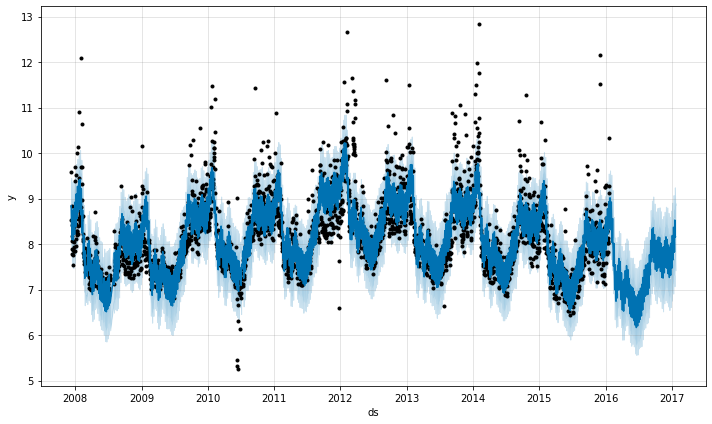

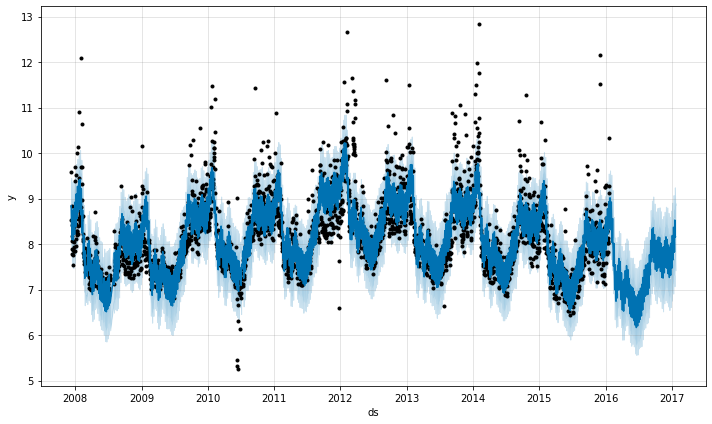

In [27]:
#plot the forecast
model.plot(prediction)

### Narrative
- A Trending data
- Black dots : the actual data points in our dataset.
- Deep blue line : the predicted forecast/the predicted values
- Light blue line : the boundaries (yhat_upper and yhat_lower)

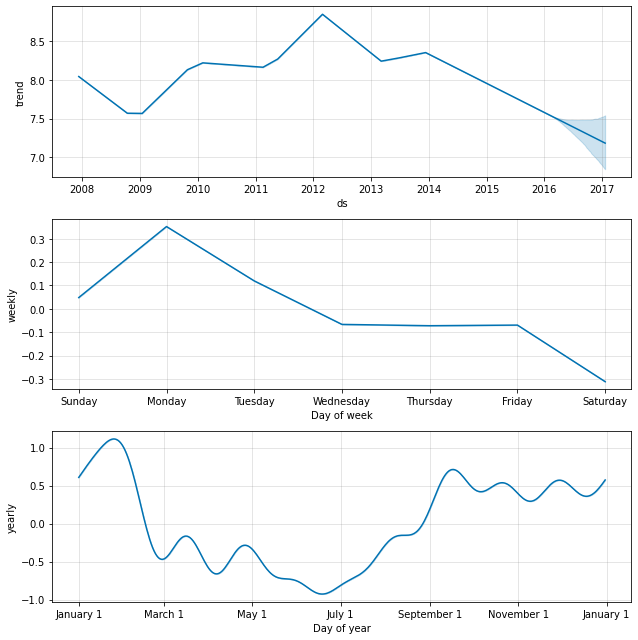

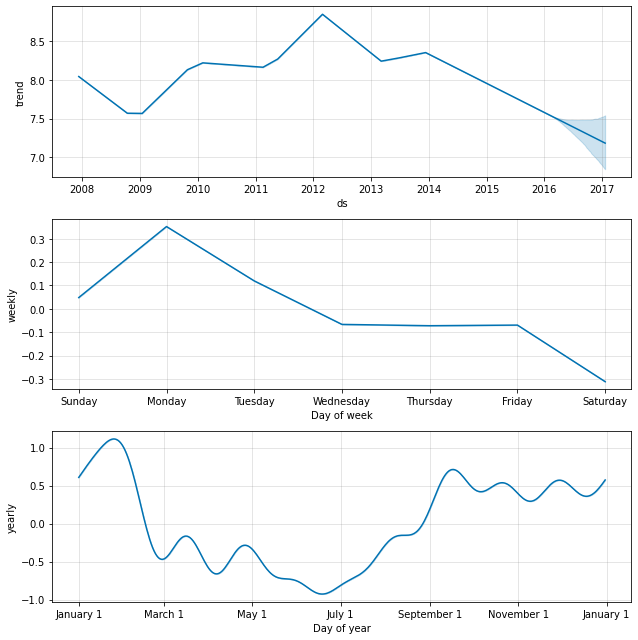

In [28]:
# Visualize Each Component [Trends,Weekly]
model.plot_components(prediction)

# 5. Evaluating the model

### Cross Validation
- For measuring forecast error by comparing the predicted values with the actual values
- initial:the size of the initial training period
- period : the spacing between cutoff dates
- horizon : the forecast horizon

In [29]:
#import packages and run cross validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 11 forecasts with cutoffs between 2010-02-15 00:00:00 and 2015-01-20 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-16,8.956994,8.474389,9.442857,8.242493,2010-02-15
1,2010-02-17,8.723424,8.235997,9.241966,8.008033,2010-02-15
2,2010-02-18,8.607185,8.108490,9.124975,8.045268,2010-02-15
3,2010-02-19,8.529051,8.012865,9.027899,7.928766,2010-02-15
4,2010-02-20,8.271035,7.776118,8.782895,7.745003,2010-02-15


### Calculating Performance metrics
- mean squared error (MSE)
- root mean squared error (RMSE)
- mean absolute error (MAE)
- mean absolute percent error (MAPE)
- median absolute percent error (MDAPE)
- coverage

In [30]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,37 days,0.495275,0.703758,0.505082,0.058504,0.686615
1,38 days,0.501173,0.707936,0.510089,0.059083,0.685473
2,39 days,0.523420,0.723478,0.516205,0.059684,0.682732
3,40 days,0.530696,0.728489,0.519055,0.059988,0.686386
4,41 days,0.538154,0.733590,0.519985,0.060060,0.693924


### Visualizing Performance Metrics

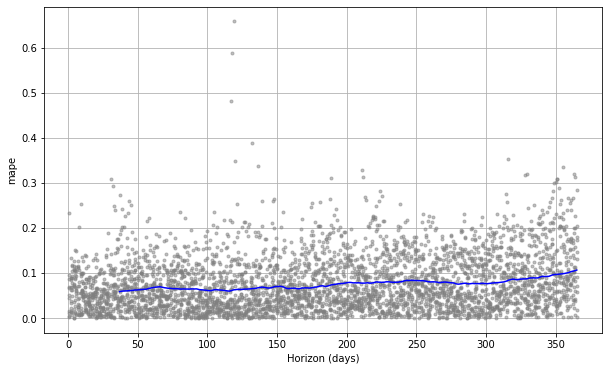

In [31]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

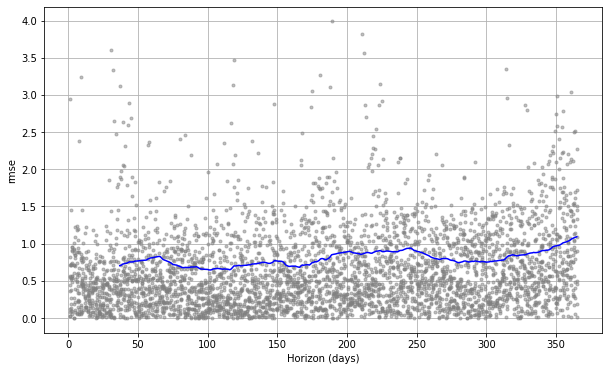

In [32]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

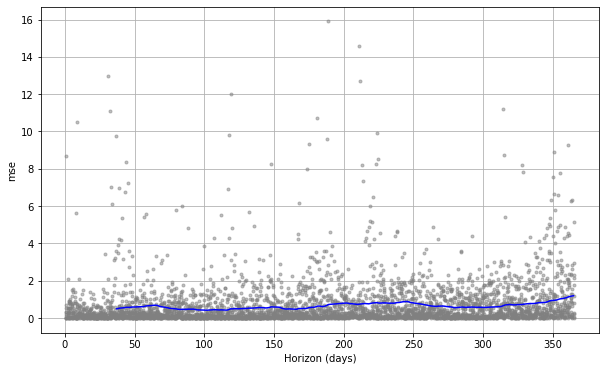

In [33]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mse')

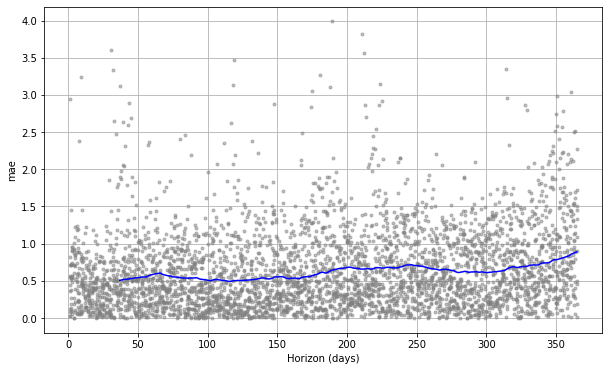

In [34]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')